# 1.1 Problem Statement:

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.
You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

### - Data Dictionary:

There are two csv files given
   - **train_1.csv:** In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

The page name contains data in this format:
SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)
   - **Exog_Campaign_eng:** This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English
Concepts Tested:
   * Exploratory data analysis
   * Time Series forecasting- ARIMA, SARIMAX, and Prophet

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
df_exog = pd.read_csv("Exog_Campaign_eng.csv")
df_exog.head()

,Exog
0,0
1,0
2,0
3,0
4,0


### shape

In [4]:
print(df.shape)
print(df_exog.shape)

(145063, 551)
(550, 1)


In [5]:
df.duplicated().sum()

0

In [6]:
df.sample(100).head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
88534,尾野真千子_ja.wikipedia.org_desktop_all-agents,822.0,1217.0,927.0,749.0,793.0,634.0,555.0,608.0,633.0,...,397.0,317.0,273.0,269.0,213.0,358.0,237.0,266.0,261.0,276.0
106101,水瀨祈_zh.wikipedia.org_mobile-web_all-agents,29.0,28.0,16.0,15.0,26.0,28.0,36.0,26.0,24.0,...,94.0,77.0,105.0,71.0,88.0,86.0,88.0,102.0,75.0,99.0
111722,LIUNA_Station_en.wikipedia.org_all-access_all-...,3.0,13.0,11.0,4.0,10.0,25.0,11.0,7.0,18.0,...,10.0,7.0,3.0,8.0,4.0,10.0,6.0,5.0,10.0,11.0
33366,John_Lewis_(Georgia_politician)_en.wikipedia.o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,43.0,59.0,32.0,47.0,23.0,49.0,41.0,29.0,44.0
136668,シン・ゴジラ_ja.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,191.0,111.0,108.0,192.0,150.0,144.0,112.0,136.0,229.0,1350.0


### Info

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


### Description of Data Frame

In [8]:
df.describe()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
count,1.243230e+05,1.242470e+05,1.245190e+05,1.244090e+05,1.244040e+05,1.245800e+05,1.243990e+05,1.247690e+05,1.248190e+05,1.247210e+05,...,1.412100e+05,1.414790e+05,1.418740e+05,1.413190e+05,1.411450e+05,1.413620e+05,1.412410e+05,1.412370e+05,1.414280e+05,1.415980e+05
mean,1.195857e+03,1.204004e+03,1.133676e+03,1.170437e+03,1.217769e+03,1.290273e+03,1.239137e+03,1.193092e+03,1.197992e+03,1.189651e+03,...,1.394096e+03,1.377482e+03,1.393099e+03,1.523740e+03,1.679607e+03,1.678302e+03,1.633966e+03,1.684308e+03,1.467943e+03,1.478282e+03
std,7.275352e+04,7.421515e+04,6.961022e+04,7.257351e+04,7.379612e+04,8.054448e+04,7.576288e+04,6.820002e+04,7.149717e+04,7.214536e+04,...,8.574880e+04,7.732794e+04,8.478533e+04,8.752210e+04,9.794534e+04,9.232482e+04,9.185831e+04,9.014266e+04,8.155481e+04,8.873567e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.300000e+01,1.300000e+01,1.200000e+01,1.300000e+01,1.400000e+01,1.100000e+01,1.300000e+01,1.300000e+01,1.400000e+01,1.400000e+01,...,2.200000e+01,2.200000e+01,2.000000e+01,2.100000e+01,2.200000e+01,2.300000e+01,2.400000e+01,2.300000e+01,2.300000e+01,2.100000e+01
50%,1.090000e+02,1.080000e+02,1.050000e+02,1.050000e+02,1.130000e+02,1.130000e+02,1.150000e+02,1.170000e+02,1.150000e+02,1.130000e+02,...,1.490000e+02,1.430000e+02,1.320000e+02,1.450000e+02,1.600000e+02,1.620000e+02,1.630000e+02,1.600000e+02,1.540000e+02,1.360000e+02
75%,5.240000e+02,5.190000e+02,5.040000e+02,4.870000e+02,5.400000e+02,5.550000e+02,5.510000e+02,5.540000e+02,5.490000e+02,5.450000e+02,...,6.070000e+02,5.980000e+02,5.690000e+02,6.280000e+02,6.590000e+02,6.680000e+02,6.540000e+02,6.490000e+02,6.350000e+02,5.610000e+02
max,2.038124e+07,2.075219e+07,1.957397e+07,2.043964e+07,2.077211e+07,2.254467e+07,2.121089e+07,1.910791e+07,1.999385e+07,2.020182e+07,...,2.420108e+07,2.253925e+07,2.505662e+07,2.586575e+07,2.834288e+07,2.691699e+07,2.702505e+07,2.607382e+07,2.436397e+07,2.614954e+07


In [9]:
df.dtypes

Page           object
2015-07-01    float64
2015-07-02    float64
2015-07-03    float64
2015-07-04    float64
               ...   
2016-12-27    float64
2016-12-28    float64
2016-12-29    float64
2016-12-30    float64
2016-12-31    float64
Length: 551, dtype: object

In [10]:
df.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [11]:
df.isnull().sum()[range(1,550,25)]

2015-07-01    20740
2015-07-26    19865
2015-08-20    18923
2015-09-14    18407
2015-10-09    17771
2015-11-03    15734
2015-11-28    15847
2015-12-23    14647
2016-01-17    13667
2016-02-11    12057
2016-03-07    11485
2016-04-01    10385
2016-04-26     9679
2016-05-21     9216
2016-06-15     8071
2016-07-10     7836
2016-08-04     6917
2016-08-29     6022
2016-09-23     5457
2016-10-18     4858
2016-11-12     4234
2016-12-07     4130
dtype: int64

We can see here there are lot of the null values, somlets visulaise the null values and lets perform the analysis for the same

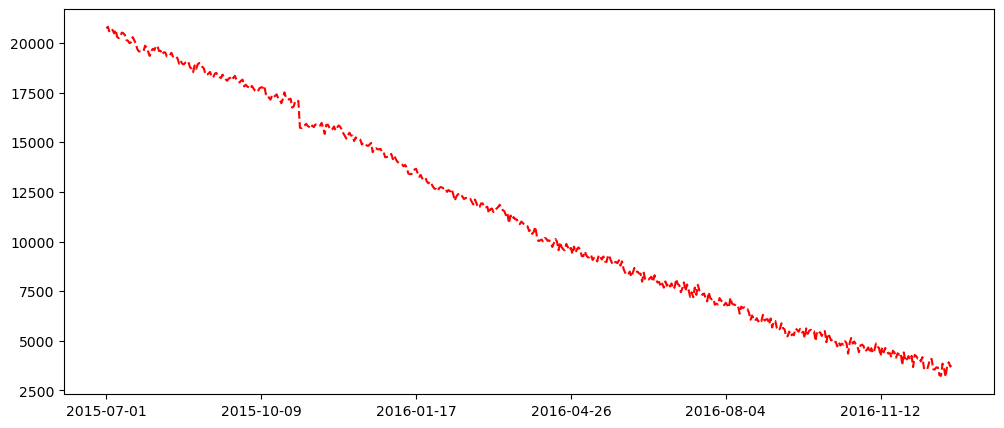

In [12]:
#Visualizing Null-values count for all columns
plt.figure(figsize=(12, 5))
df.iloc[:, 1:-3 ].isnull().sum().plot(color='red', linestyle='dashed')
plt.show()

**=> The plot indicates a decreasing trend in NaN / Null values over time. Pages created or hosted more recently tend to have fewer Null values compared to those created earlier.**

**=> This is because pages created or hosted later will naturally have Null values only for previous dates, before the page was created or hosted.**

**=> To clean the data, we will drop rows with more than 300 Null values and replace the remaining Null values with 0.**

In [13]:
df.dropna(thresh = 300, inplace = True)
print(f'Shape of Data : {df.shape}')

Shape of Data : (133617, 551)


In [14]:
df.isnull().sum()

Page             0
2015-07-01    9666
2015-07-02    9683
2015-07-03    9442
2015-07-04    9561
              ... 
2016-12-27     901
2016-12-28     943
2016-12-29     959
2016-12-30     941
2016-12-31     677
Length: 551, dtype: int64

In [15]:
df.interpolate(method='linear', inplace=True)

Interpolate will handle the null values by filling them with estimates based on the surrounding data, allowing for a more complete and continuous dataset for analysis.

In [16]:
df.isnull().sum()

Page          0
2015-07-01    0
2015-07-02    0
2015-07-03    0
2015-07-04    0
             ..
2016-12-27    0
2016-12-28    0
2016-12-29    0
2016-12-30    0
2016-12-31    0
Length: 551, dtype: int64

In [17]:
df['Page_name'] = df['Page'].str.split(".")

In [18]:
df[:2]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Page_name
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,"[2NE1_zh, wikipedia, org_all-access_spider]"
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,"[2PM_zh, wikipedia, org_all-access_spider]"


In [19]:
df['Language'] = df['Page_name'][0][0]

In [20]:
df['wiki'] = df['Page_name'][0][1]
df['Acess'] = df['Page_name'][0][2]

In [21]:
df.drop(columns={"Page_name"}, inplace=True)

## Function to Extract Language from Page using Regex

In [22]:


def get_language(name):
    if len(re.findall(r'_(.{2}).wikipedia.org_', name)) == 1 : 
        return re.findall(r'_(.{2}).wikipedia.org_', name)[0]
    else: return 'Unknown_language'

In [23]:
df['lang_word'] = df['Page'].apply(get_language)

In [24]:
language_dict ={'de':'German',
                'en':'English', 
                'es': 'Spanish', 
                'fr': 'French', 
                'ja': 'Japenese' , 
                'ru': 'Russian', 
                'zh': 'Chinese',
                'Unknown_language': 'Unknown_language'}

In [25]:
df['lang_word'] = df['lang_word'].map(language_dict)

## Visualizing distribution of various languages

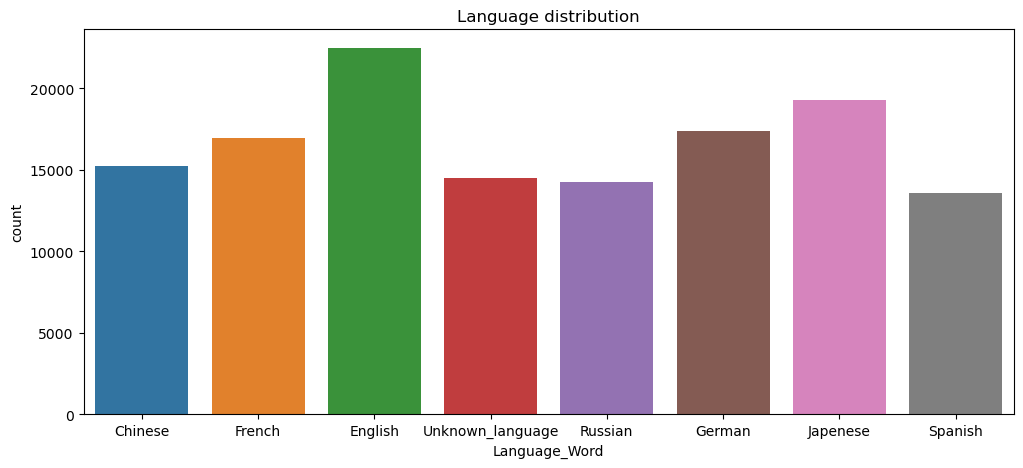

In [26]:
plt.figure(figsize=(12,5))
sns.countplot(x=df['lang_word'], data=df)
plt.title("Language distribution")
plt.ylabel('count')
plt.xlabel("Language_Word")
plt.show()

The graph indicates that **English** is the most significant language in the dataset. Its prominence and attributes make it a key focus for interpreting the time series data.

In [27]:
df[df['lang_word'] == "Unknown_language"].count()[0]

14494

**Approximately 14,000 rows lack information about the language considered as "Unknown Language" Around 9.21%**

## Function to Extract Access Type from Page using Regex

In [28]:
def get_access_type(name):
    if len(re.findall(r'all-access|mobile-web|desktop', name)) == 1 : 
        return re.findall(r'all-access|mobile-web|desktop', name)[0]
    else: return 'No Access_type'

In [29]:
df['access_type'] = df['Page'].apply(get_access_type)

## Visualizing Access types Distribution

In [30]:
df['access_type'].value_counts()

all-access    68718
mobile-web    33299
desktop       31600
Name: access_type, dtype: int64

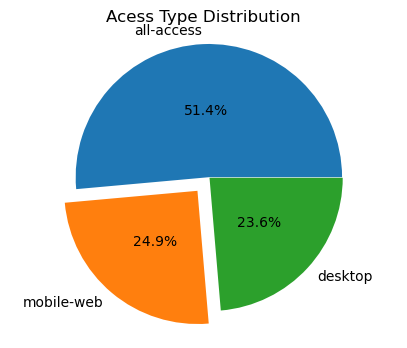

In [31]:
plt.figure(figsize=(5, 4))
plt.pie(x=df['access_type'].value_counts(), explode=[0,0.2,0.01],labels=df['access_type'].value_counts().index, radius=1.5,
        autopct='%1.1f%%', pctdistance=0.5)
plt.title("Acess Type Distribution")
plt.axis('equal')
plt.show()

## Accessing the origin

In [32]:
def get_access_origin(name):
    if len(re.findall(r'[ai].org_(.*)_(.*)$', name)) == 1 : 
        return re.findall(r'[ai].org_(.*)_(.*)$', name)[0][1]
    else: return 'No Access_origin'

In [33]:
df['access_origin'] = df['Page'].apply(get_access_origin)

In [34]:
df['access_origin'].value_counts()

all-agents    101303
spider         32314
Name: access_origin, dtype: int64

# Visualizing Access Origin Distribution¶

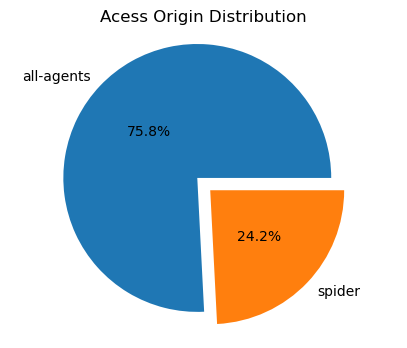

In [35]:
plt.figure(figsize=(5, 4))
plt.pie(x=df['access_origin'].value_counts(), explode=[0,0.2],labels=df['access_origin'].value_counts().index,
        radius=1.5,autopct='%1.1f%%', pctdistance=0.5)
plt.title("Acess Origin Distribution")
plt.axis('equal')
plt.show()

In [36]:
df[:3]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Language,wiki,Acess,lang_word,access_type,access_origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,22.0,19.0,18.0,20.0,2NE1_zh,wikipedia,org_all-access_spider,Chinese,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,52.0,45.0,26.0,20.0,2NE1_zh,wikipedia,org_all-access_spider,Chinese,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,3.0,4.0,17.0,2NE1_zh,wikipedia,org_all-access_spider,Chinese,all-access,spider


# Preprocessing Data

#### Grouping  Aggregation and transposing

In [37]:
df_language = df.groupby(by=["lang_word"]).mean().T
df_language[:4]

lang_word,Chinese,English,French,German,Japenese,Russian,Spanish,Unknown_language
2015-07-01,303.239132,4615.475941,863.374937,785.653610,621.708229,672.734631,1232.253737,115.208176
2015-07-02,286.724223,4578.492151,515.762196,773.129542,712.598499,681.179667,1182.191561,121.000745
2015-07-03,285.348752,4342.156788,496.477001,743.645743,642.160535,631.773882,1082.437671,113.214592
2015-07-04,282.550404,4511.400738,539.733660,681.756502,807.572864,594.503606,1016.594089,98.798296


#### Dropiing the Unknown langauge, as it does not concern any interpretation

In [38]:
df_language.drop(columns=["Unknown_language"],inplace=True)

In [39]:
df_language.reset_index(inplace=True)

In [40]:
df_language.set_index("index", inplace=True)

In [41]:
df_language[:2]

lang_word,Chinese,English,French,German,Japenese,Russian,Spanish
index,,,,,,,
2015-07-01,303.239132,4615.475941,863.374937,785.653610,621.708229,672.734631,1232.253737
2015-07-02,286.724223,4578.492151,515.762196,773.129542,712.598499,681.179667,1182.191561


# Visualisating the languages and outcomes

In [42]:
x = df_language.mean().sort_values(ascending = False).index
y = df_language.mean().sort_values(ascending = False).values

In [43]:
print(x)
print(y)

Index(['English', 'Spanish', 'Russian', 'German', 'Japenese', 'French',
       'Chinese'],
      dtype='object', name='lang_word')
[4938.42495982 1292.74816116 1013.99601925  930.11565183  799.30375984
  681.95087058  366.99309249]


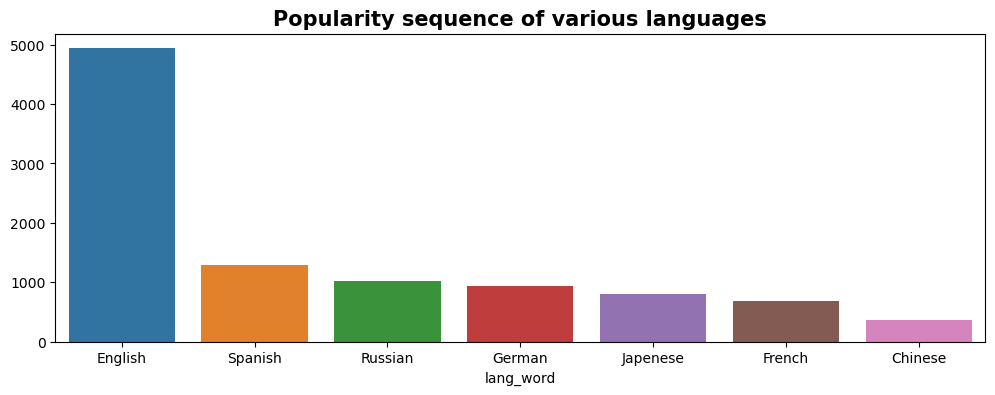

In [44]:
plt.figure(figsize=(12, 4))
sns.barplot(x=x,y=y)
plt.title(f'Popularity sequence of various languages', fontsize = 15, fontweight = 'bold')
plt.show()

# Time Series Plots

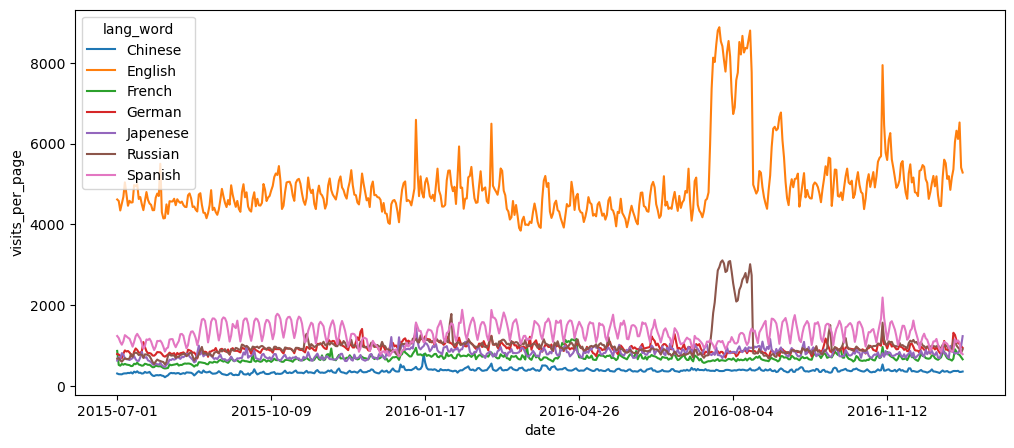

In [45]:
df_language.plot(label = df_language.columns,  figsize=(12,5))
plt.xlabel("date")
plt.ylabel("visits_per_page")
plt.show()

# Checking Stationarity using ADF (Augmented Dickey Fuller) Test

 **ADF Test**
- **Null Hypothesis:** The series has a unit root (value of a=1). The series is non-stationary.

- **Alternate Hypothesis:** The series has no unit root. The series is stationary.

- If we fail to reject the null hypothesis, we can say that the series is non-stationary.
- If p_value < 0.05 (alpha) or test statistic is less than the critical value, then we can reject the null hypothesis (aka the series is stationary)

In [46]:
def adf_test(data, significance_level=0.05, autolag='AIC'):
    pvalue = adfuller(data)[1]
    if pvalue <= significance_level:
        print(pvalue)
        print('Sequence is stationary')
    else:
        print(pvalue)
        print('Sequence is not stationary')

In [47]:
print("English")
adf_test(df_language['English'])
print("*"*20)
print("Chinese")
adf_test(df_language['Chinese'])
print("*"*20)
print("French")
adf_test(df_language['French'])
print("*"*20)
print("German")
adf_test(df_language['German'])
print("*"*20)
print("Japenese")
adf_test(df_language['Japenese'])
print("*"*20)
print("Russian")
adf_test(df_language['Russian'])
print("*"*20)
print("Spanish")
adf_test(df_language['Spanish'])

English
0.05401851179011414
Sequence is not stationary
********************
Chinese
0.2515581418844101
Sequence is not stationary
********************
French
0.03583317912475713
Sequence is stationary
********************
German
0.11272242669954013
Sequence is not stationary
********************
Japenese
0.05321045401406782
Sequence is not stationary
********************
Russian
0.001751538208633705
Sequence is stationary
********************
Spanish
0.05099313297806498
Sequence is not stationary


# Decomposing Time Series

                     
$y_{t}$ =  $T_{t}$ +  $S_{t}$  +  $R_{t}$

where 
- $y_{t}$ = actual value in time series
- $T_{t}$ = trend in time series
- $S_{t}$ = seasonality in time series
- $R_{t}$ = residuals of time series

In [48]:
timeseries_english = df_language['English'].values

In [49]:
decompose = seasonal_decompose(timeseries_english, model="additive", period=7)

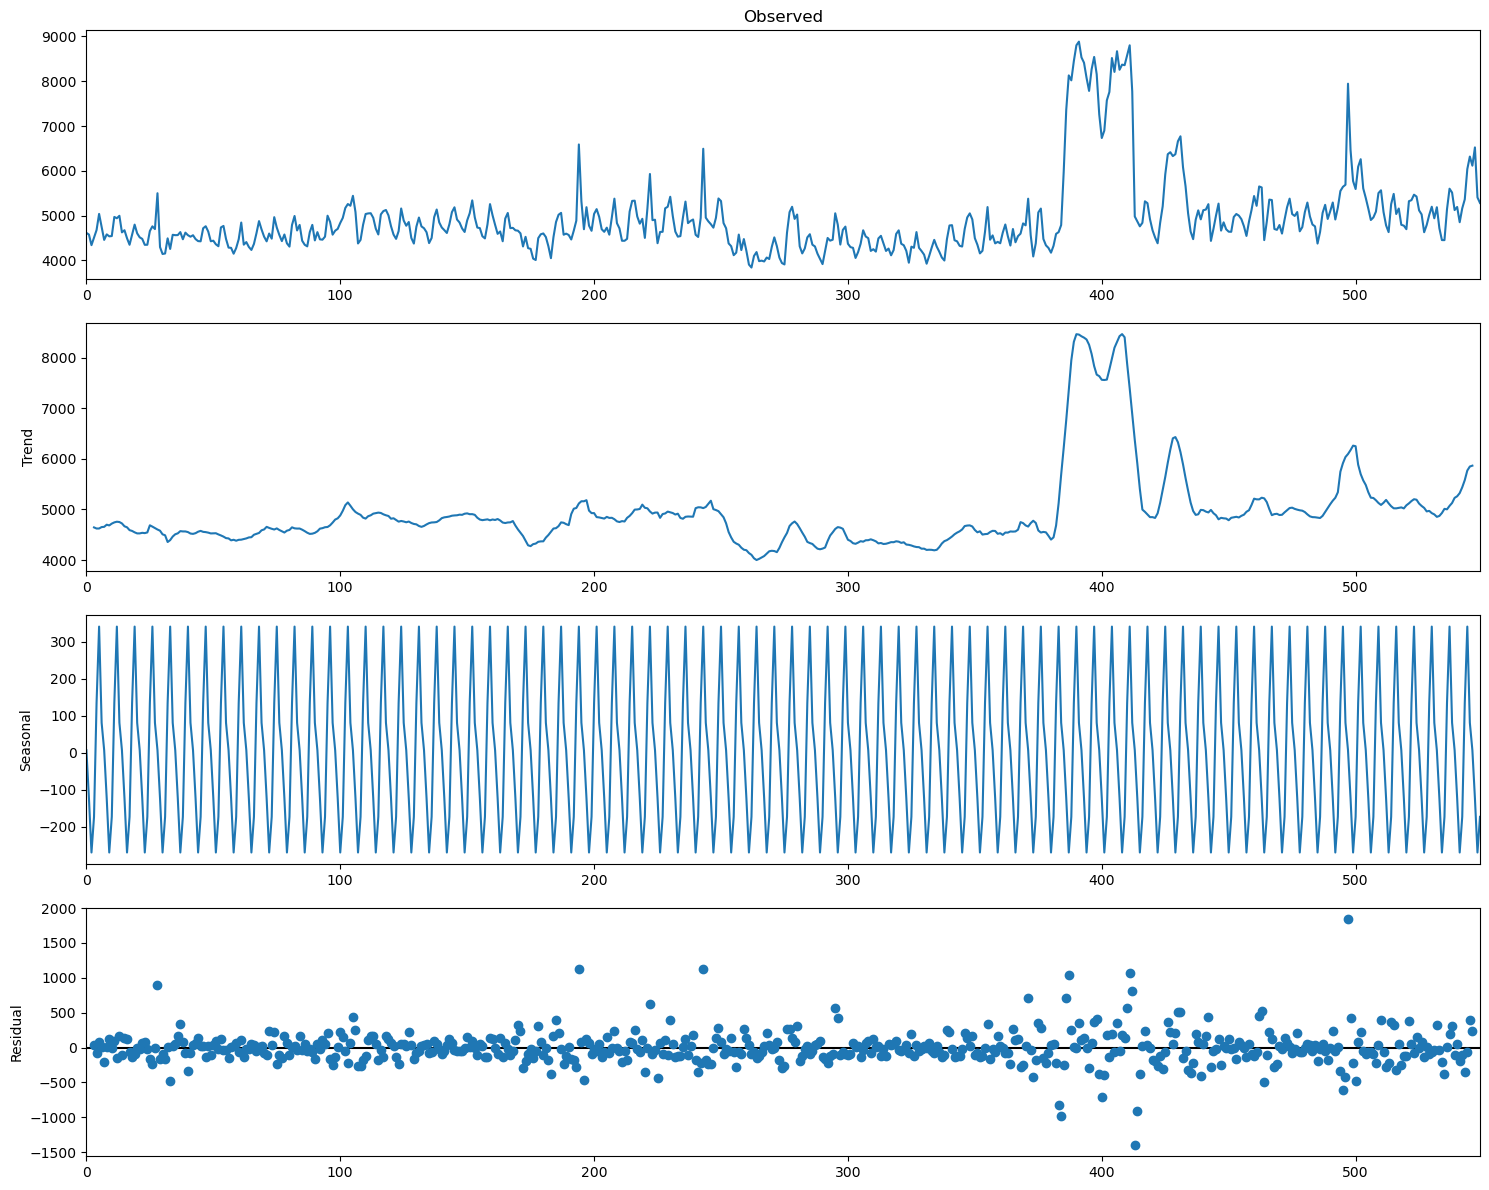

In [50]:
fig = decompose.plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

# Checking Residuals is stationary or not

In [51]:
residuals= pd.DataFrame(decompose.resid).fillna(0)[0].values

In [52]:
adf_test(residuals)

6.62076689845654e-21
Sequence is stationary


**The test statistic is less than the critical value / the p-value is less than 5%.**

The ADF (Augmented Dickey-Fuller) Test indicates that the **residuals** from the time series decomposition are **stationary**.

## Getting insights into time series characteristics

**Using ACF and PACF plots**

### Estimating (p,q,d) & Interpreting ACF and PACF plots 

In [53]:
df_tsenglish = pd.DataFrame(timeseries_english).diff(1)
df_tsenglish.dropna(inplace=True)

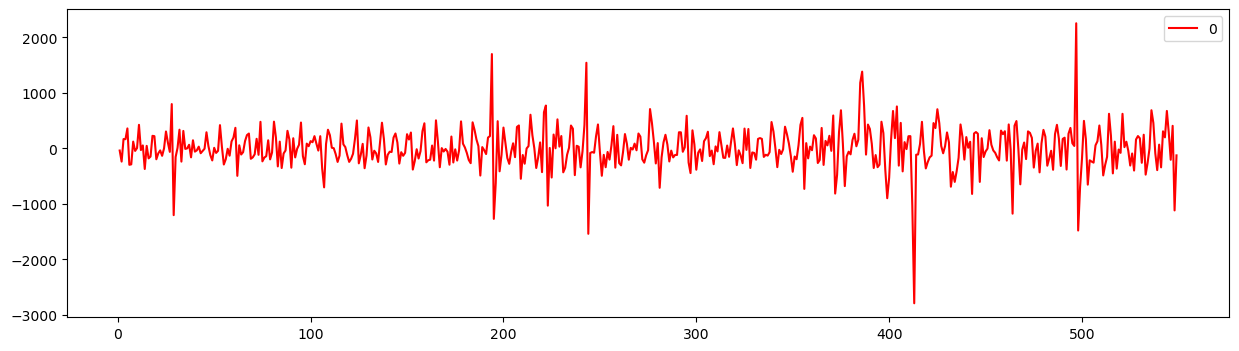

In [54]:
df_tsenglish.plot(color = 'red', figsize=(15, 4))
plt.show()

Here, we are analyzing the most prevalent language, which is English, and we know that the trend is non-stationary. Therefore, to use the ACF and PACF plots, we need to differentiate the series to achieve stationarity for further analysis.
Differencing can transform a nonstationary series into a stationary one, making it easier to analyze and predict future behavior.
Remember that differencing is just one of the preprocessing steps in time series analysis, and it plays a crucial role in achieving meaningful insights and accurate forecasts.📈

### Checking for Dicky Adfuller for stationary or non stationary

In [55]:
adf_test(df_tsenglish)

4.18277112822857e-13
Sequence is stationary


**After differencing once, the time series becomes stationary. This suggests that for the ARIMA model, we can set d = 1.**

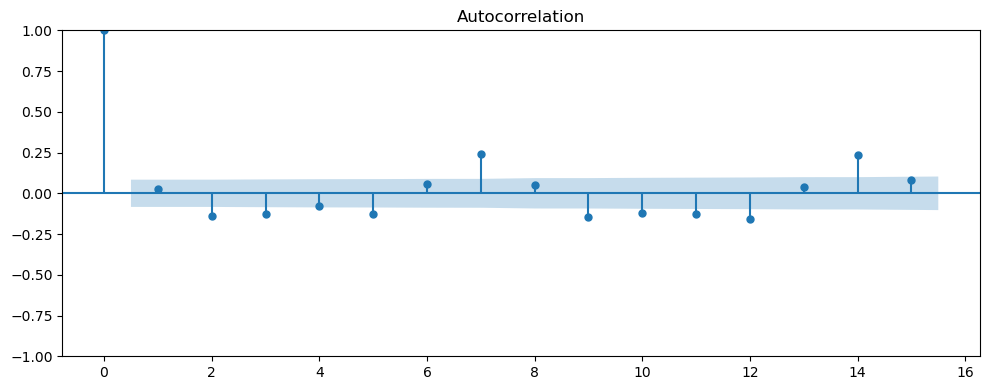

In [56]:
acf = plot_acf(df_tsenglish, lags= 15)
acf.set_size_inches((10,4))
acf.tight_layout()

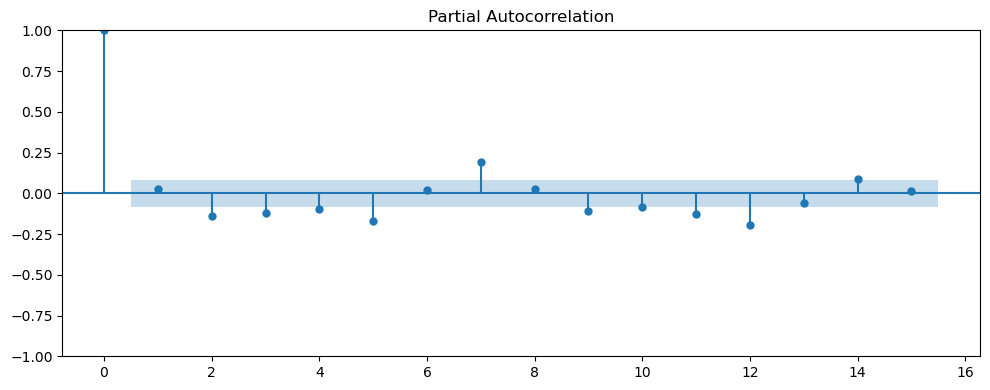

In [57]:
pacf = plot_pacf(df_tsenglish, lags= 15)
pacf.set_size_inches((10, 4))
pacf.tight_layout()

# Forecasting Model Creation

### creating base model

In [58]:
model = ARIMA(df_language['English'], order =(1,1,1))
model_fit = model.fit()

### Forecasting

In [59]:
forecast = model_fit.forecast(steps = 30)

### Plotting Actual and Forecasted

In [60]:
df_language['English'].index =  df_language['English'].index.astype('datetime64[ns]')

In [61]:
forecast.index = forecast.index.astype('datetime64[ns]')

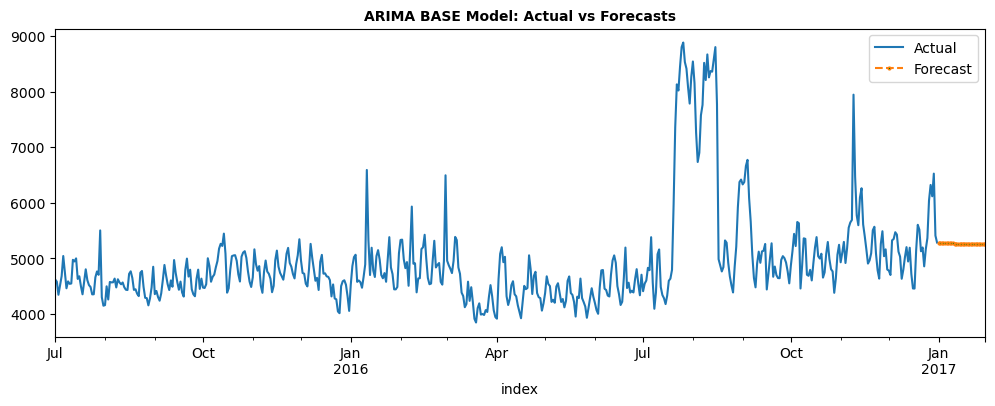

In [62]:
plt.figure(figsize = (12,4))
df_language['English'].plot(label = 'Actual')
forecast.plot(label = 'Forecast', linestyle='dashed', marker='o',markerfacecolor='green', markersize=2)
plt.legend(loc="upper right")
plt.title('ARIMA BASE Model: Actual vs Forecasts', fontsize = 10, fontweight = 'bold')
plt.show()

### Calculating MAPE & RMSE

In [63]:
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

In [64]:
performance(df_language['English'][-30:], forecast)

MAE : 369.339
RMSE : 496.335
MAPE: 0.07


**ARIMA Base model has ~7% MAPE and RMSE ~ 500.**

# Creation for function for SARIMAX model 

In [65]:
n=30
time_series = df_language.English.copy(deep = True)
def sarimax_model(time_series, n, p=0, d=0, q=0, P=0, D=0, Q=0, s=0, exog = []):
    model = SARIMAX(df_language['English'][:-n],
                    order =(p,d,q), 
                    seasonal_order=(P, D, Q, s), 
                    exog = exog[:-n],
                    initialization='approximate_diffuse')
    model_fit = model.fit()

### Creating forecast for last n-values

In [66]:
model_forecast = model_fit.forecast(n, dynamic = True)

### plotting Actual & Forecasted values

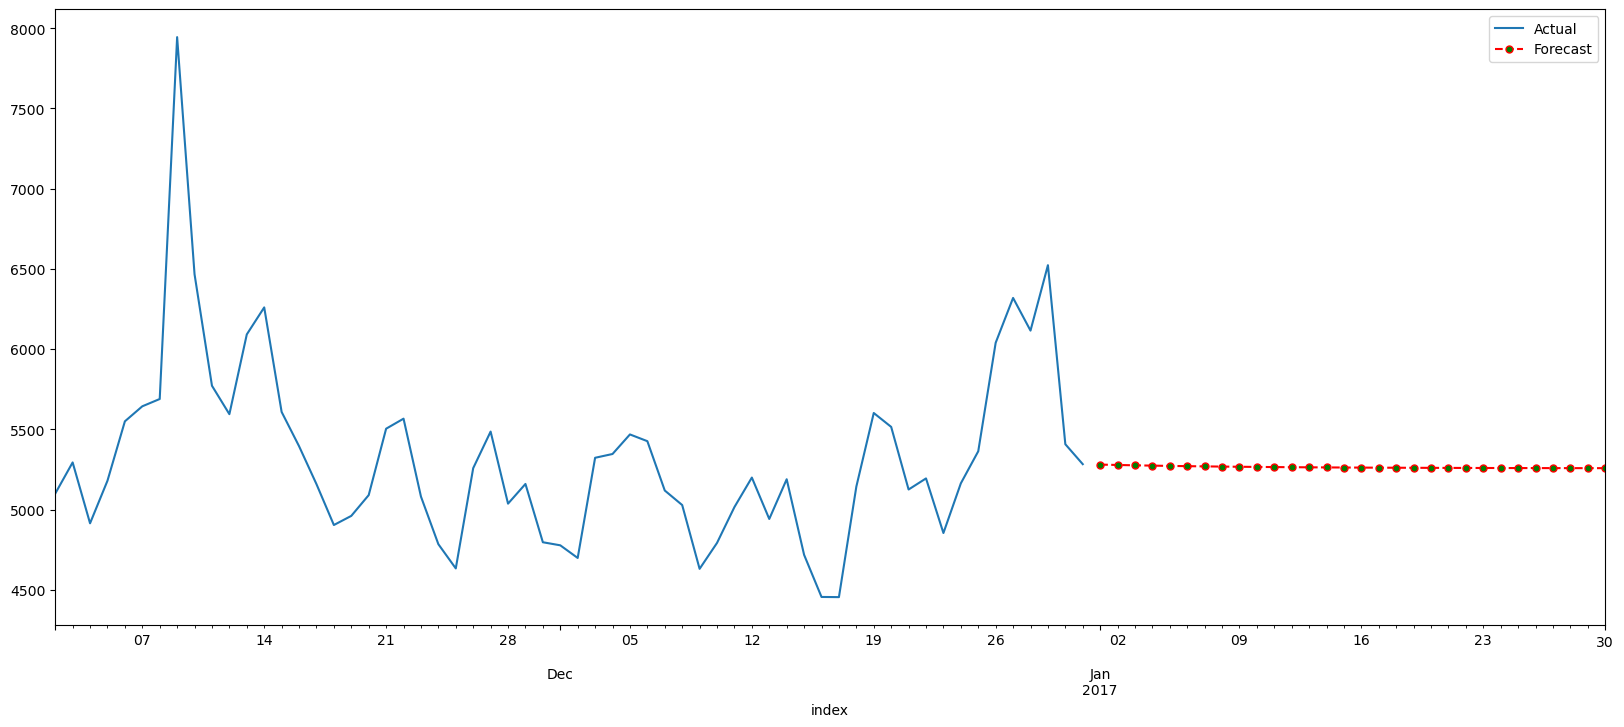

In [67]:
time_series.index = time_series.index.astype('datetime64[ns]')
model_forecast.index = model_forecast.index.astype('datetime64[ns]')
plt.figure(figsize = (20,8))
time_series[-60:].plot(label = 'Actual')
model_forecast[-60:].plot(label = 'Forecast', color = 'red', 
                              linestyle='dashed', marker='o',markerfacecolor='green', markersize=5)
plt.legend(loc="upper right")
# plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
plt.show()

### Calculating MAPE & RMSE

In [68]:
actuals = df_language['English'].values[-n:]

In [69]:
errors = df_language['English'].values[-n:] - model_forecast.values

In [70]:
mape = np.mean(np.abs(errors)/ np.abs(actuals))
rmse = np.sqrt(np.mean(errors**2))

print('-'*40)
print(f'MAPE of Model : {np.round(mape,5)}')
print('-'*40)
print(f'RMSE of Model : {np.round(rmse,3)}')
print('-'*40)

----------------------------------------
MAPE of Model : 0.06993
----------------------------------------
RMSE of Model : 496.335
----------------------------------------


### Checking a SARIMAX model with seasonality (p,d,q,P,D,Q,s = 1,1,1,1,1,1,7)

In [71]:
exog = df_exog['Exog'].to_numpy()
time_series = df_language['English']
test_size= 0.1
p,d,q, P,D,Q,s = 1,1,1,1,1,1,7
n = 30

In [72]:
model = SARIMAX(time_series, exog = exog,  order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit(disp=False)

In [73]:
predictions = results.forecast(n, exog = df_exog['Exog'][-30:])

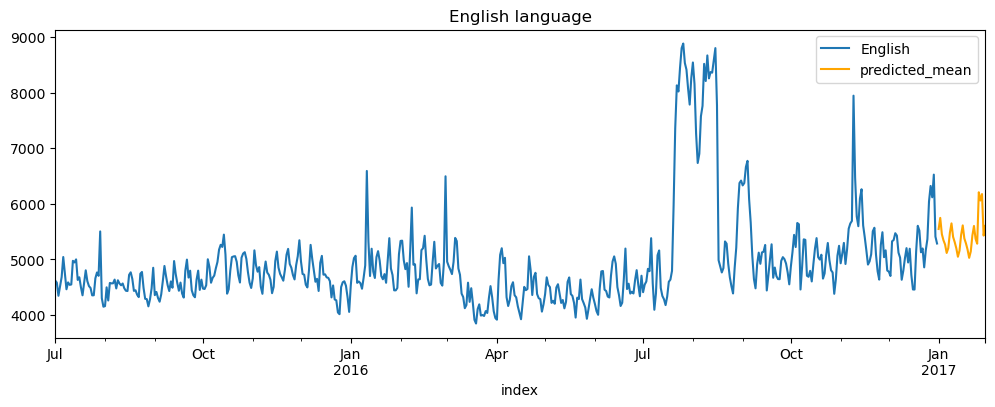

In [74]:
plt.figure(figsize=(12,4))
title='English language'
ylabel='Numbers'
xlabel='Months'
ax = time_series.plot(legend=True,title=title)
predictions.plot(legend=True,color = 'orange')
plt.show()

==> **SIMPLE SARIMAX model has ~6.9% MAPE and RMSE ~ 500.**

==> Impact of Seasonality & exogenous variable was captured properly in this model. 

In [75]:
import os, io, sys, setuptools, tokenize

In [76]:
!pip install prophet

In [77]:
import prophet

In [78]:
from prophet import Prophet

In [79]:
time_series = df_language
time_series = time_series.reset_index()
time_series = time_series[['index', 'English']]
time_series.columns = ['ds', 'y']
exog = df_exog.copy(deep = True)
time_series['exog'] = exog.values

In [80]:
time_series

,ds,y,exog
0,2015-07-01,4615.475941,0
1,2015-07-02,4578.492151,0
2,2015-07-03,4342.156788,0
3,2015-07-04,4511.400738,0
4,2015-07-05,4678.685249,0
...,...,...,...
545,2016-12-27,6318.971160,1
546,2016-12-28,6115.246131,1
547,2016-12-29,6523.169572,1
548,2016-12-30,5407.129481,0


00:12:46 - cmdstanpy - INFO - Chain [1] start processing
00:12:46 - cmdstanpy - INFO - Chain [1] done processing


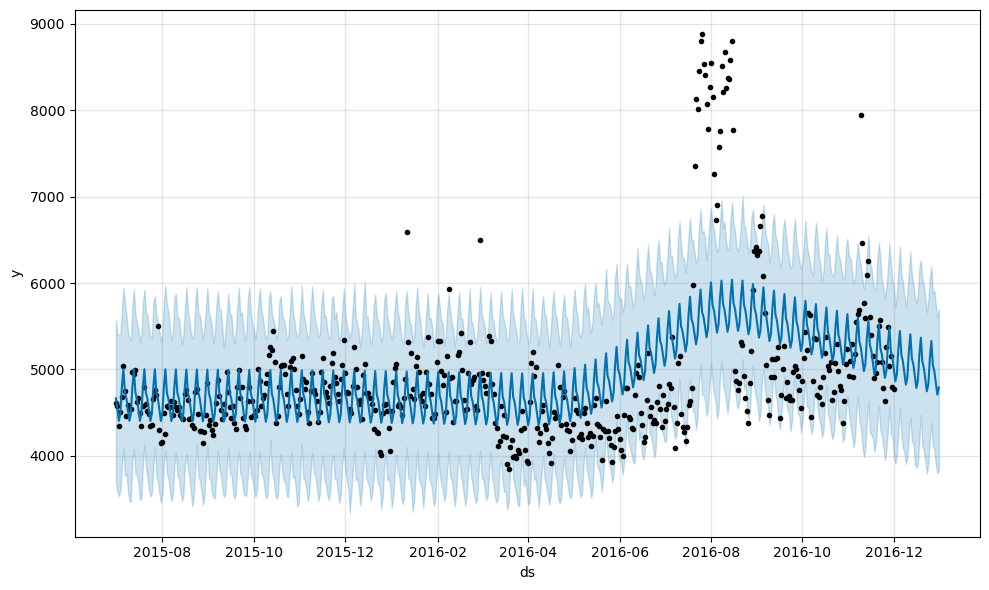

In [81]:
prophet1 = Prophet(weekly_seasonality=True)
prophet1.fit(time_series[['ds', 'y']][:-30])
future = prophet1.make_future_dataframe(periods=30, freq= 'D')
forecast = prophet1.predict(future)
fig1 = prophet1.plot(forecast)

**The graph displays the actual data points as black dots, while the blue line represents the time series trend of the data. The shaded area, bounded by the graded lines, illustrates the lower and upper bounds of the forecast. This forecast was generated using Facebook's Prophet time series model with an additive approach. The model provides predictions for the dataset for the next 30 weeks.**

In [82]:
forecast[-5:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
545,2016-12-27,4982.553856,4119.568514,5882.773653,4951.634089,5009.581415,68.539659,68.539659,68.539659,68.539659,68.539659,68.539659,0.0,0.0,0.0,5051.093515
546,2016-12-28,4977.005172,4067.162904,5909.756841,4944.410193,5006.362142,1.435852,1.435852,1.435852,1.435852,1.435852,1.435852,0.0,0.0,0.0,4978.441024
547,2016-12-29,4971.456487,3893.548215,5743.321410,4936.935724,5002.820699,-123.793549,-123.793549,-123.793549,-123.793549,-123.793549,-123.793549,0.0,0.0,0.0,4847.662939
548,2016-12-30,4965.907803,3797.114745,5604.633490,4929.312259,4999.086996,-258.078260,-258.078260,-258.078260,-258.078260,-258.078260,-258.078260,0.0,0.0,0.0,4707.829543
549,2016-12-31,4960.359119,3821.329361,5701.132239,4920.685988,4996.716658,-169.423171,-169.423171,-169.423171,-169.423171,-169.423171,-169.423171,0.0,0.0,0.0,4790.935948


In [83]:
prophet1.component_modes

{'additive': ['weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

# Trends for Weeks and yearly

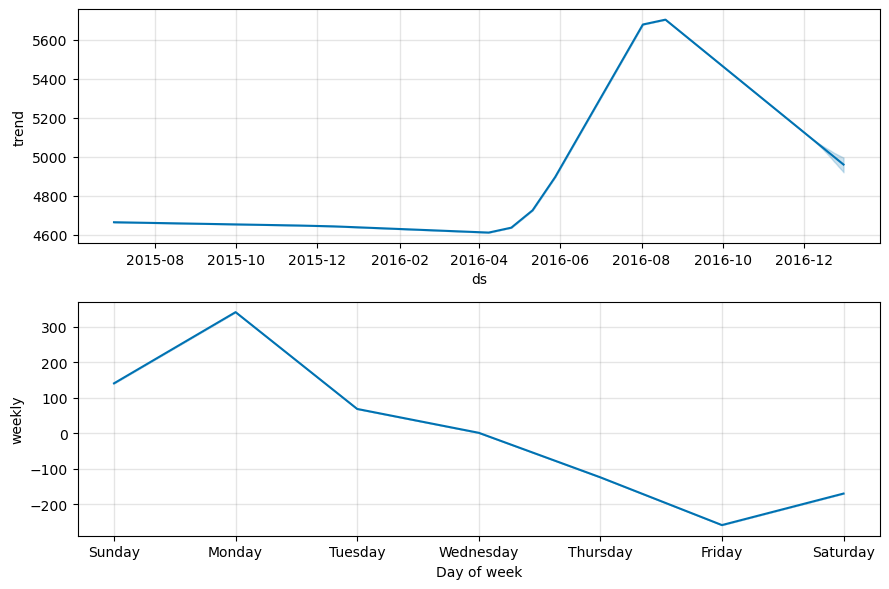

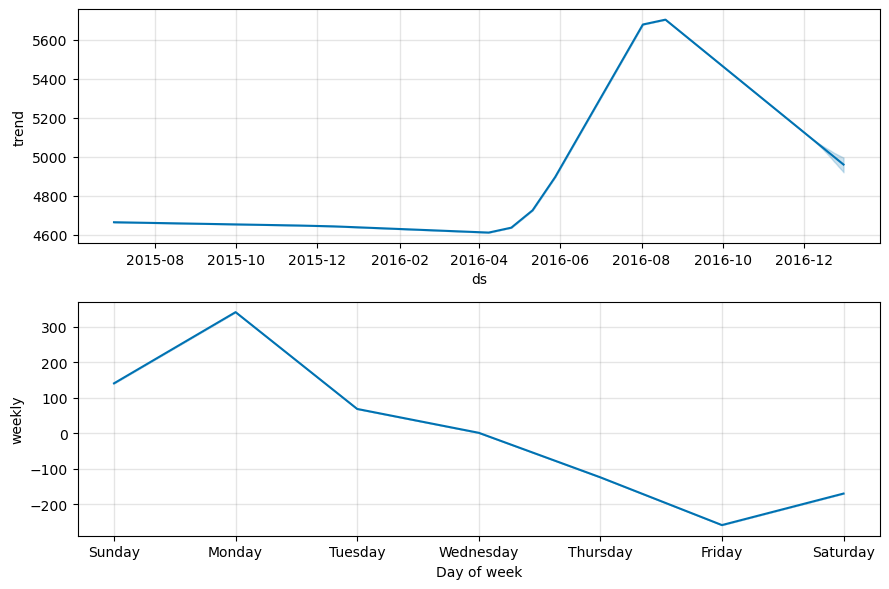

In [84]:
prophet1.plot_components(forecast)

00:12:49 - cmdstanpy - INFO - Chain [1] start processing
00:12:49 - cmdstanpy - INFO - Chain [1] done processing


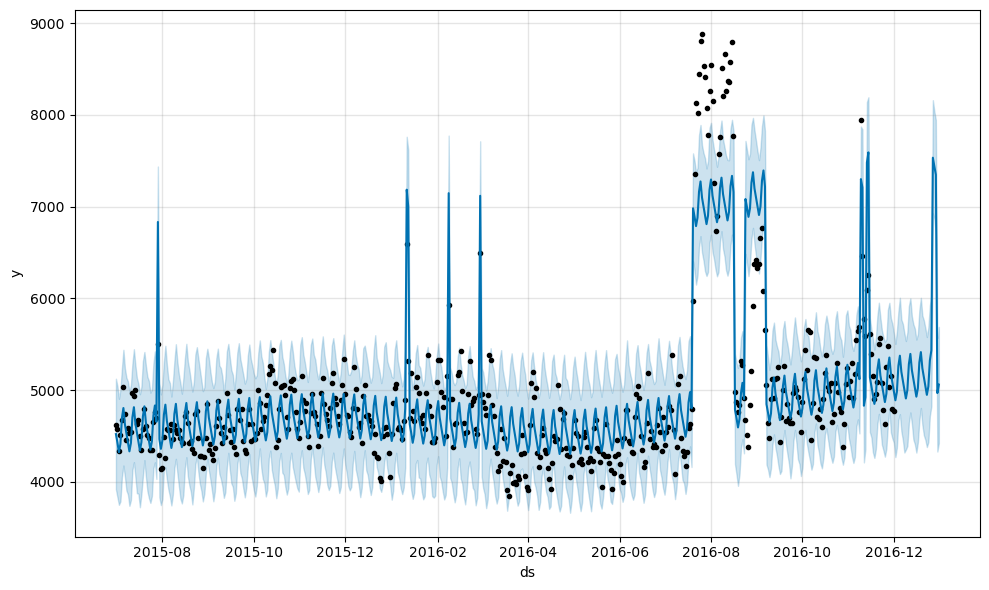

In [85]:
prophet2 = Prophet(weekly_seasonality=True)
prophet2.add_regressor('exog')
prophet2.fit(time_series[:-30])
#future2 = prophet2.make_future_dataframe(periods=30, freq= 'D')
forecast2 = prophet2.predict(time_series)
fig2 = prophet2.plot(forecast2)

In [86]:
actual = time_series['y'].values
forecast = forecast2['yhat'].values

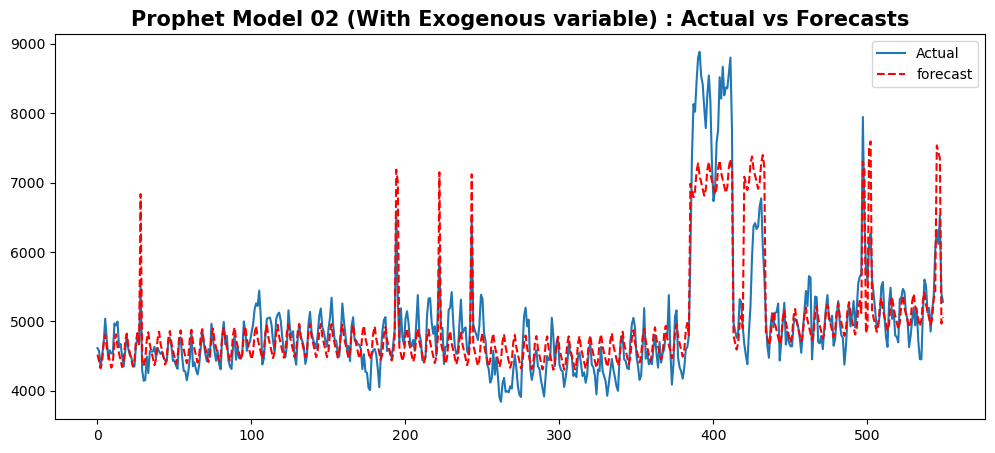

In [87]:
plt.figure(figsize = (12,5))
plt.plot(actual, label = 'Actual')
plt.plot(forecast, label = 'forecast', color = 'red', linestyle='dashed')
plt.legend(loc="upper right")
plt.title(f'Prophet Model 02 (With Exogenous variable) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
plt.show()

# Error

In [88]:
errors = abs(actual - forecast)
mape = np.mean(errors/abs(actual))
mape

0.05741098660281426

The FB Prophet model has been successfully developed and appears to produce a reliable forecast. This model effectively captures peaks due to the inclusion of an exogenous variable. The overall Mean Absolute Percentage Error (MAPE) for the **Prophet model is approximately 6%.**

# Decision and Recommendations

In [89]:
best_param_df  = pd.DataFrame(columns = ['language','p','d', 'q', 'P','D','Q','s','mape'])

In [90]:
new_row = ['English',1,1,1,2,1,1,7, 0.04189]
best_param_df.loc[len(best_param_df)] = new_row

In [91]:
best_param_df.sort_values(['mape'], inplace = True)
best_param_df

,language,p,d,q,P,D,Q,s,mape
0,English,1,1,1,2,1,1,7,0.04189


In [92]:
mean_visits = pd.DataFrame(df_language.mean()).reset_index()
mean_visits.columns = ['language', 'mean_visits']
df_visit_mape = best_param_df.merge(mean_visits, on = 'language')
df_visit_mape

,language,p,d,q,P,D,Q,s,mape,mean_visits
0,English,1,1,1,2,1,1,7,0.04189,4938.42496


# Questionnaire

### **Defining the problem statements and where can this and modifications of this be used?**

We are part of Ad Ease's Data Science team, focusing on analyzing per-page view reports for various Wikipedia pages over a span of 550 days. Our goal is to forecast the number of views to help predict and optimize ad placements for our clients. 

We have data for 145,000 Wikipedia pages, detailing daily view counts for each. Since our clients operate in different regions, they require insights into how their ads will perform on pages in various languages.

By developing an accurate forecasting model to predict visit fluctuations, we can assist the business team in optimizing marketing expenditures. Accurate predictions of high-traffic days will allow the business to strategically place ads on those days, reaching a broader audience with the most efficient use of funds.

### Write 3 inferences you made from the data visualizations

Based on the provided data, we identified content in seven languages. English has the highest number of pages, followed by Japanese, German, and French.

The data includes three access types: All-access (51.4%), mobile-web (24.9%), and desktop (23.6%).

There are also two access origins: all-agents (75.8%) and spider (24.2%).

**Recommendations:**

- **English**: With the highest number of pages, low MAPE, and high mean visits, English pages are the top choice for advertisements. Prioritizing ads on these pages will likely yield the best results.
- **Chinese**: These pages have the lowest number of visits. Advertisements should generally be avoided here unless there's a specific strategy targeting the Chinese audience.
- **Russian**: Russian pages have a reasonable number of visits and low MAPE. When utilized effectively, these pages can achieve high conversion rates.
- **Spanish**: Despite having the second-highest number of visits, Spanish pages have the highest MAPE, indicating that ads on these pages might not effectively reach the audience.
- **French, German, and Japanese**: These languages exhibit moderate visit levels and MAPE values. Advertisements should be considered on these pages based on the target audience.

### What does the decomposition of series do?

The decomposition of a time series is a statistical process that breaks down a time series into multiple components, each representing different underlying patterns. There are two main types of decomposition: additive and multiplicative. 

In this business case, we have used the additive model to decompose the time series. In an additive model, the individual components (trend, seasonality, and residual) are summed together, as illustrated in the following equation:
\[ y_t = T_t + S_t + R_t \]

where:

- \( y_t \) is the actual value in the time series,
- \( T_t \) represents the trend in the time series,
- \( S_t \) denotes the seasonality in the time series,
- \( R_t \) indicates the residuals of the time series.

### What level of differencing gave you a stationary series?

- A non-stationary time series can be transformed into a stationary time series using a technique called differencing. Differencing involves calculating the change between consecutive data points in the series.

\[ y'_t = y_t - y_{t-1} \]

This process is known as first-order differencing.

- In some cases, applying first-order differencing once is not sufficient to achieve stationarity. In such situations, second-order differencing may be necessary.

- Seasonal differencing involves calculating the change between the same period in different seasons. Given a seasonal period of \( m \):

\[ y'_t = y_t - y_{t-m} \]

- Once the time series becomes stationary, no further differencing is needed.

### Difference between arima, sarima & sarimax.

The ARIMA model is essentially an ARMA model with an additional preprocessing step, represented by \( I(d) \). The \( I(d) \) component indicates the differencing order, which is the number of transformations required to make the data stationary. Therefore, an ARIMA model is simply an ARMA model applied to the differenced time series.

In SARIMA models, there is an additional set of autoregressive and moving average components to account for seasonality. These additional lags correspond to the seasonal frequency (e.g., 12 for monthly data, 24 for hourly data). SARIMA models allow for both seasonal and non-seasonal differencing of the data.

SARIMAX model takes into account exogenous variables, or in other words, use external data in our forecast. Some real-world examples of exogenous variables include gold price, oil price, outdoor temperature, exchange rate.

### Compare the number of views in different languages

The mean number of views (popularity sequence) for various languages is as follows:

1. English
2. Spanish
3. Russian
4. German
5. Japanese
6. French
7. Chinese

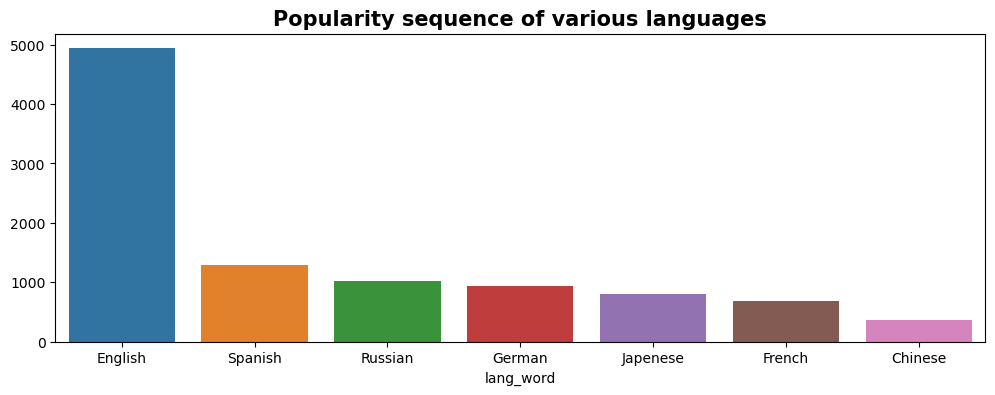

In [93]:
x = df_language.mean().sort_values(ascending = False).index
y = df_language.mean().sort_values(ascending = False).values

plt.figure(figsize=(12, 4))
sns.barplot(x=x,y=y)
plt.title(f'Popularity sequence of various languages', fontsize = 15, fontweight = 'bold')
plt.show()